In [2]:
import numpy as np
import scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import math_module
from math_module import xp
import iefc_2dm 
import utils
from imshows import *

math_module.update_np(np)
math_module.update_scipy(scipy)

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

import misc_funs as misc

import hcipy_models as hcim
reload(hcim)

reload(hci)
npix = 256
oversample = 2
c = hcim.SVC(npix=npix, oversample=oversample)



In [3]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)


34 952


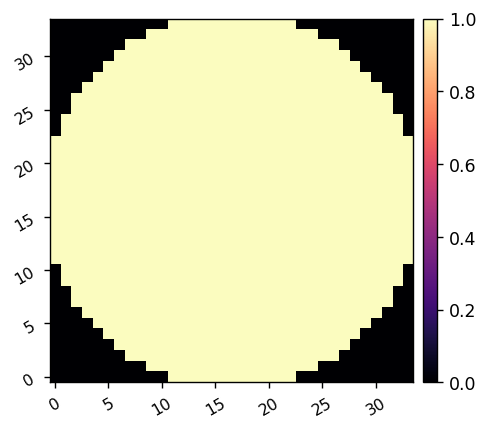

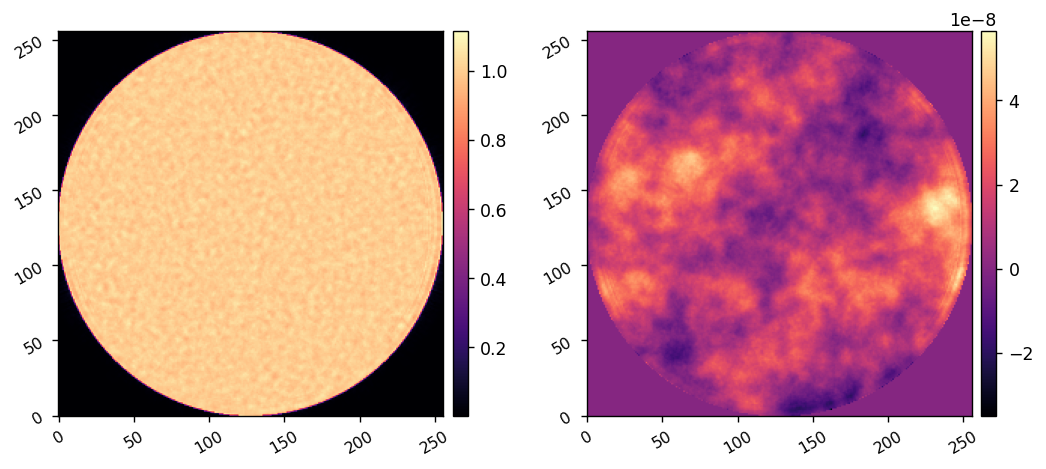

0.05531861851804018 1.732283029032913e-08


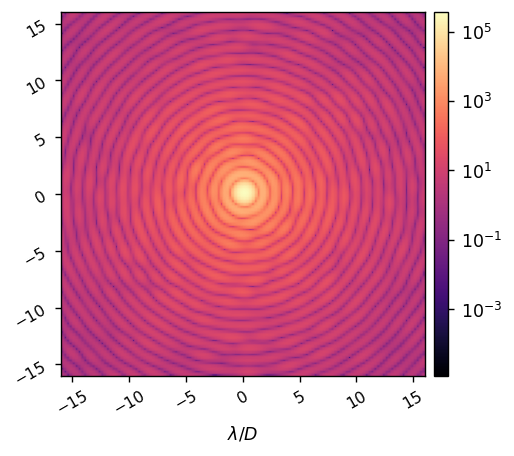

361229.2294707936


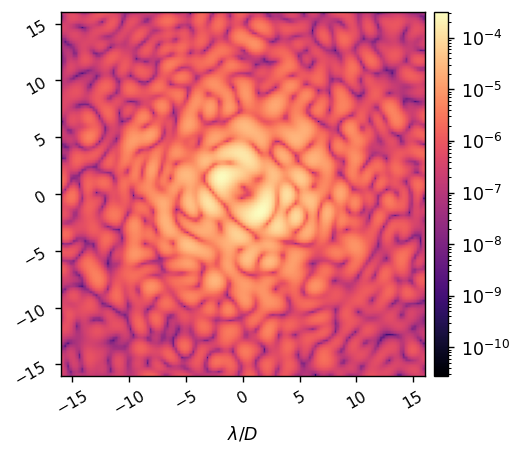

In [7]:
reload(hcim)
svc = hcim.SVC(npix=npix, oversample=oversample,
                 influence_functions=influence_functions,
                 ptv=50*u.nm,
                 psf_pixelscale_lamD=1/4,
                 dm1_dm2=1000*u.mm,
                 aberration_distance=50e-3*u.m)

print(svc.Nact, svc.Nacts)
imshow1(svc.dm_mask)

wf = hci.Wavefront(svc.aperture, svc.wavelength.to_value(u.m))
pupil_mask = wf.amplitude.shaped.astype(bool)
wf = svc.wfe_at_distance(wf)


amp = wf.amplitude.shaped
opd = wf.phase.shaped*svc.wavelength.to_value(u.m)/(2*np.pi)*pupil_mask
imshow2(amp, opd, npix=svc.npix)

rms_amp = np.sqrt(np.mean((amp[pupil_mask]-1)**2))
rms_wfe = np.sqrt(np.mean(opd[pupil_mask]**2))
print(rms_amp, rms_wfe)

svc.use_fpm = False
svc.norm = 1
ref_unocc_im = svc.snap()
imshow1(ref_unocc_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.max()
print(max_ref)

svc.use_fpm = True
svc.norm = max_ref # divide the source flux to get nominal contrast images
ref_im = svc.snap()
imshow1(ref_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# define the dark hole region

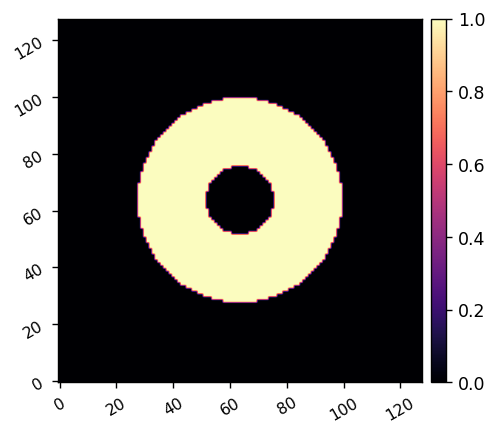

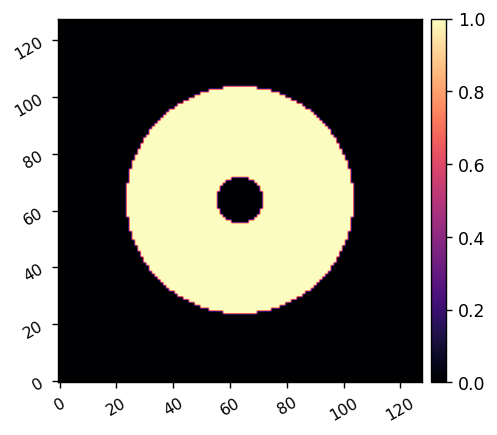

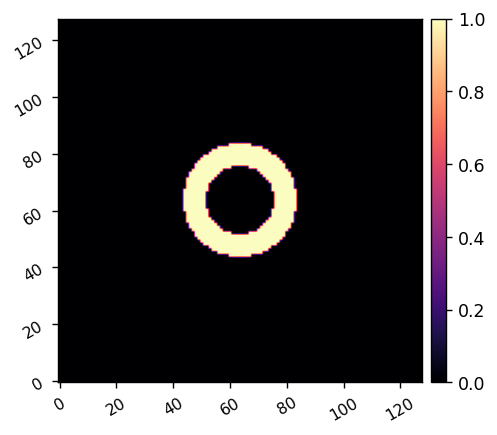

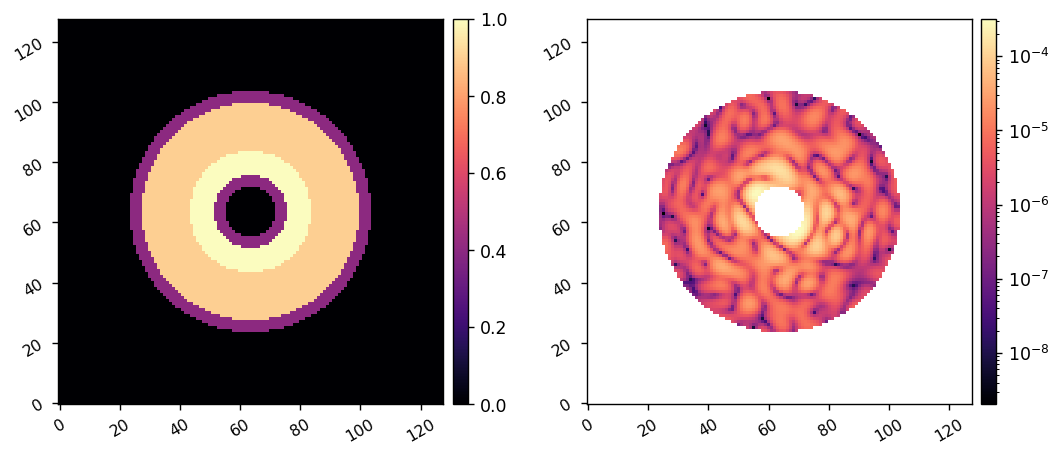

1.318572309756478e-05


In [8]:
reload(utils)

npsf = svc.npsf

roi1 = utils.create_annular_focal_plane_mask(svc, inner_radius=3, outer_radius=9, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(svc, inner_radius=3, outer_radius=5, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

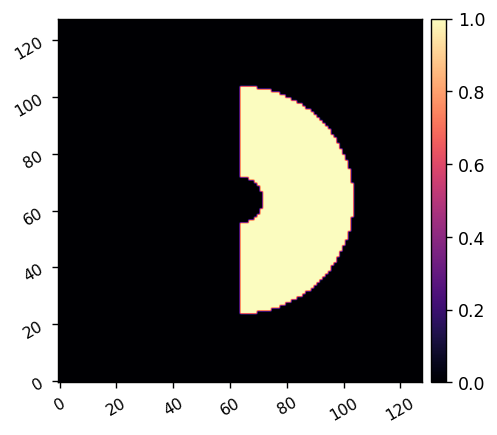

(640, 2312)

(160, 2)

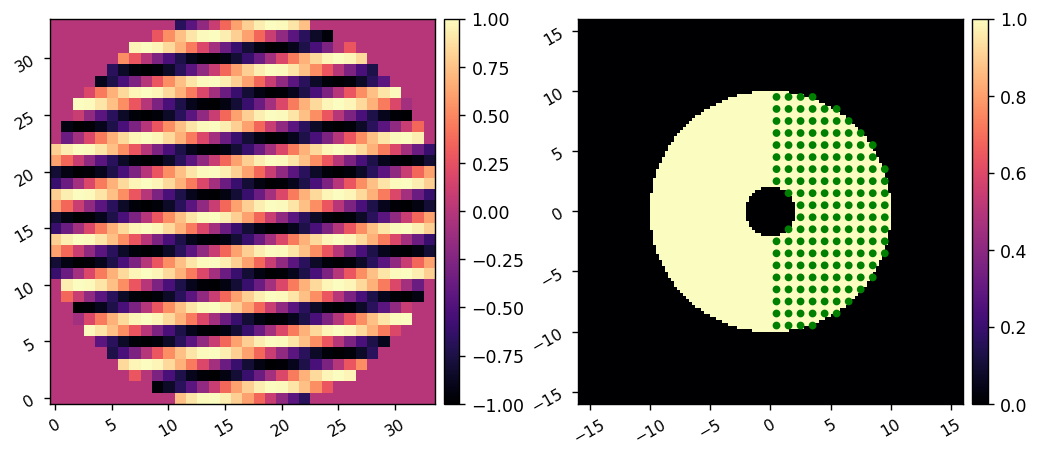

In [13]:
reload(utils)
fourier_mask = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=0, plot=True)

calib_modes, fs = utils.create_fourier_modes(svc, fourier_mask, fourier_sampling=1, return_fs=True, ndms=2) 
nmodes = calib_modes.shape[0]
nf = calib_modes.shape[0]//2
display(calib_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))

imshow2(calib_modes[5, :svc.Nact**2].reshape(svc.Nact,svc.Nact), control_mask, 
             patches2=patches, pxscl2=svc.psf_pixelscale_lamD)
# wfssvc.imshow1(ref_im, lognorm=True, pxscl=svc.psf_pixelscale_lamD, patches=patches)


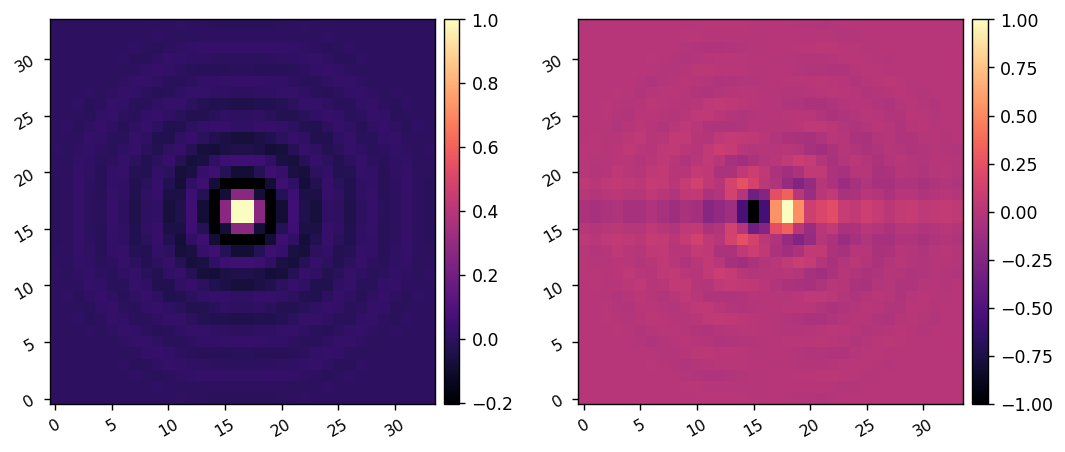

In [17]:
reload(utils)
probe_amp = 2.5e-8
fourier_svcs, fs = utils.select_fourier_svcs(svc, control_mask*(fpx>0), fourier_sampling=0.5) 
probe_svcs = utils.create_fourier_probes(fourier_svcs, Nact=svc.Nact, plot=True)
# probe_svcs = np.append(probe_svcs, probe_svcs[1], axis=0)
# probe_svcs = np.array([probe_svcs[1], np.rot90(probe_svcs[1])])
# wfsc.imshow2(probe_svcs[0], probe_svcs[1])

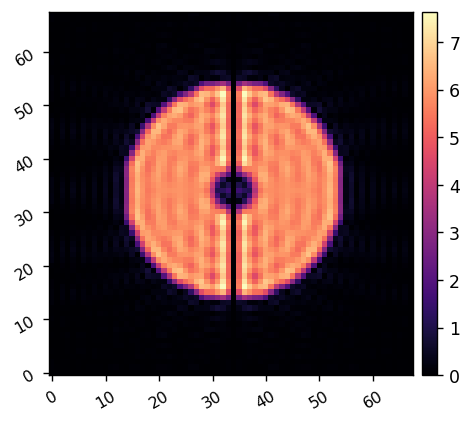

In [20]:
probe_response = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(utils.pad_or_crop(probe_svcs[1], 2*probe_svcs[0].shape[0])))))
imshow1(probe_response)

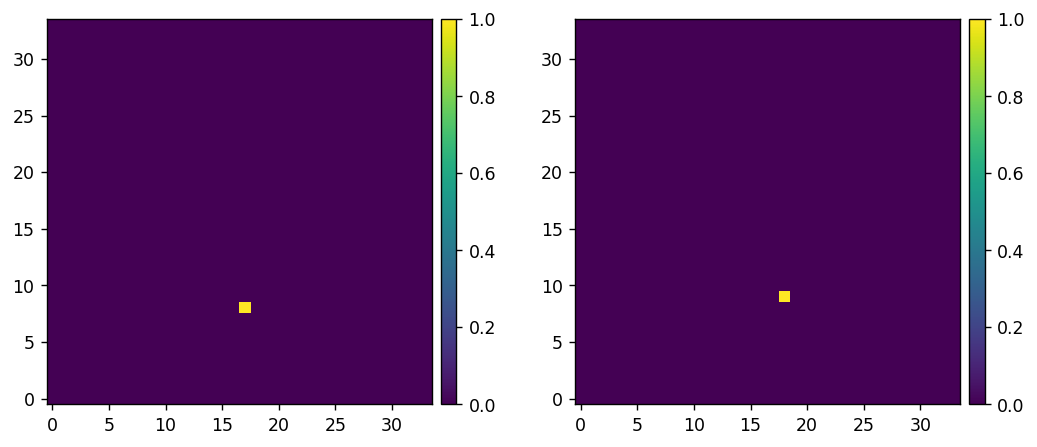

In [21]:
probe_svcs = utils.create_probe_poke_svcs(poke_indices=[(c.Nact//2, c.Nact//4), (c.Nact//2+1, c.Nact//4+1)], Nact=c.Nact, plot=True)

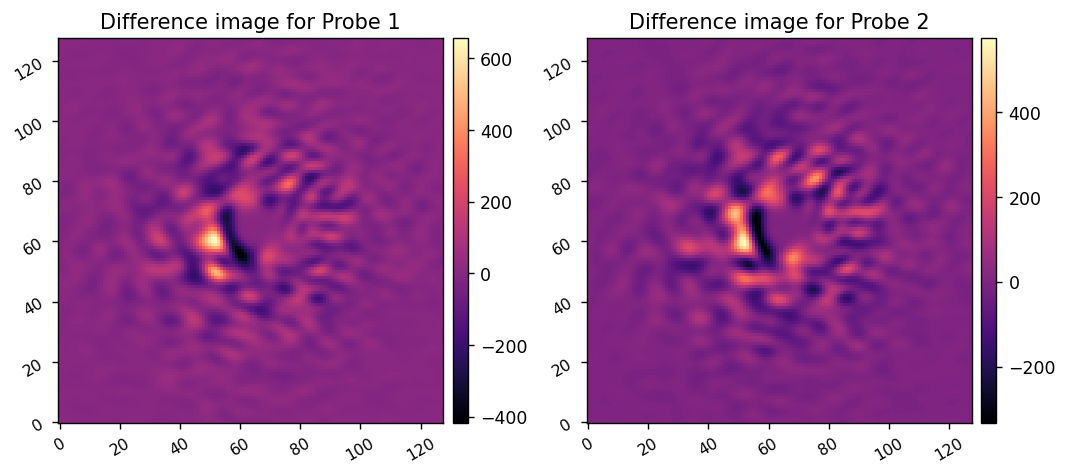

In [23]:
reload(iefc_2dm)

probe_amp = 5e-8
calib_amp = 5e-9

# c.texp = 1

svc.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(svc, 
                                                                   probe_svcs, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(probe_svcs.shape[0], svc.npsf, svc.npsf)
imshow2(ims[0], ims[1], 'Difference image for Probe 1', 'Difference image for Probe 2')

In [24]:
reload(iefc_2dm)
response_matrix, response_cube = iefc_2dm.calibrate(svc, 
                                                         control_mask,
                                                         probe_amp, probe_svcs, 
                                                         calib_amp, calib_svcs, 
                                                         return_all=True)

Calibrating iEFC...
	Calibrated mode 320/320 in 3622.823s
Calibration complete.


In [27]:
response_matrix.shape

(9632, 640)

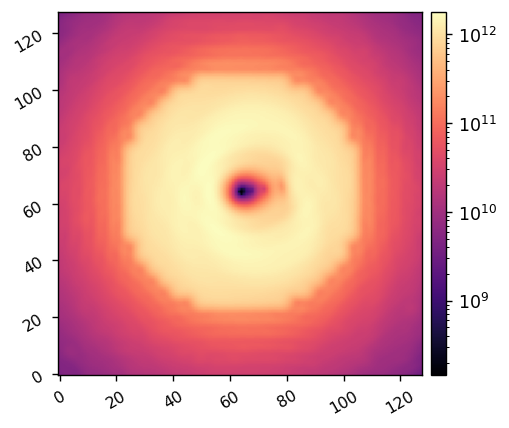

In [28]:
reload(utils)
# dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:svc.Nacts]**2, axis=0)), svc.dm_mask)
# dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[svc.Nacts:]**2, axis=0)), svc.dm_mask)
# imshow2(dm1_response , dm2_response, lognorm=True)

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(svc.npsf, svc.npsf)
imshow1(fp_response, lognorm=True)

In [20]:

date = 20230714

misc.save_fits(iefc_dir/'response-data'/f'hcipy_svc_iefc_2dm_response_matrix_{date}.fits', response_matrix)
misc.save_fits(iefc_dir/'response-data'/f'hcipy_svc_iefc_2dm_response_cube_{date}.fits', response_cube)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_iefc_2dm_response_matrix_20230714.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_iefc_2dm_response_cube_20230714.fits


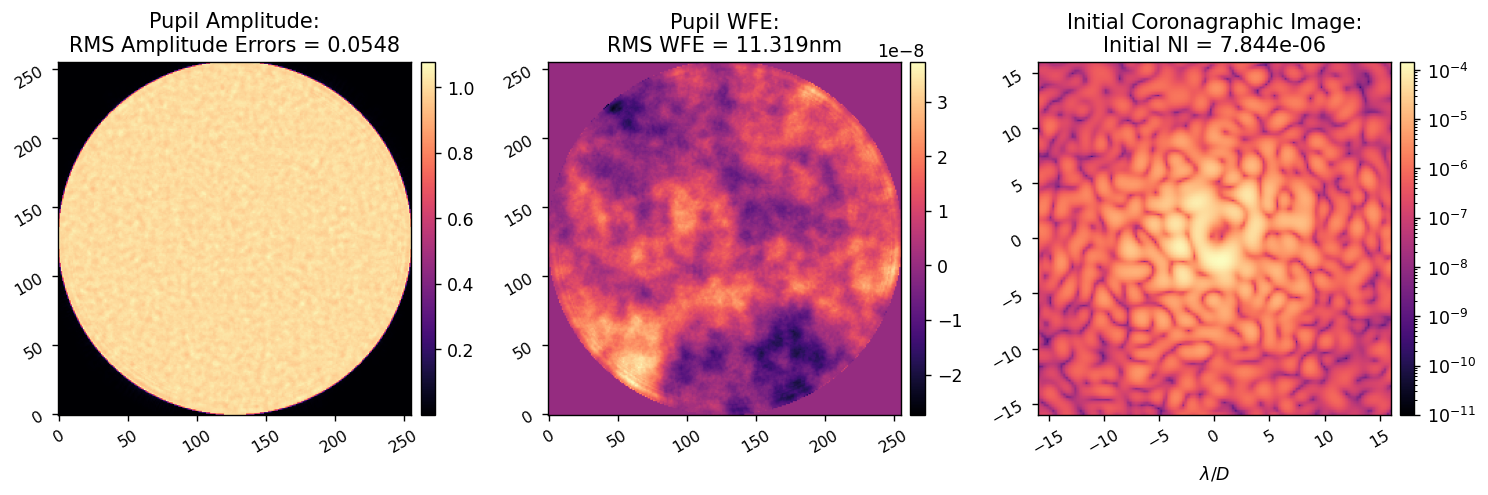

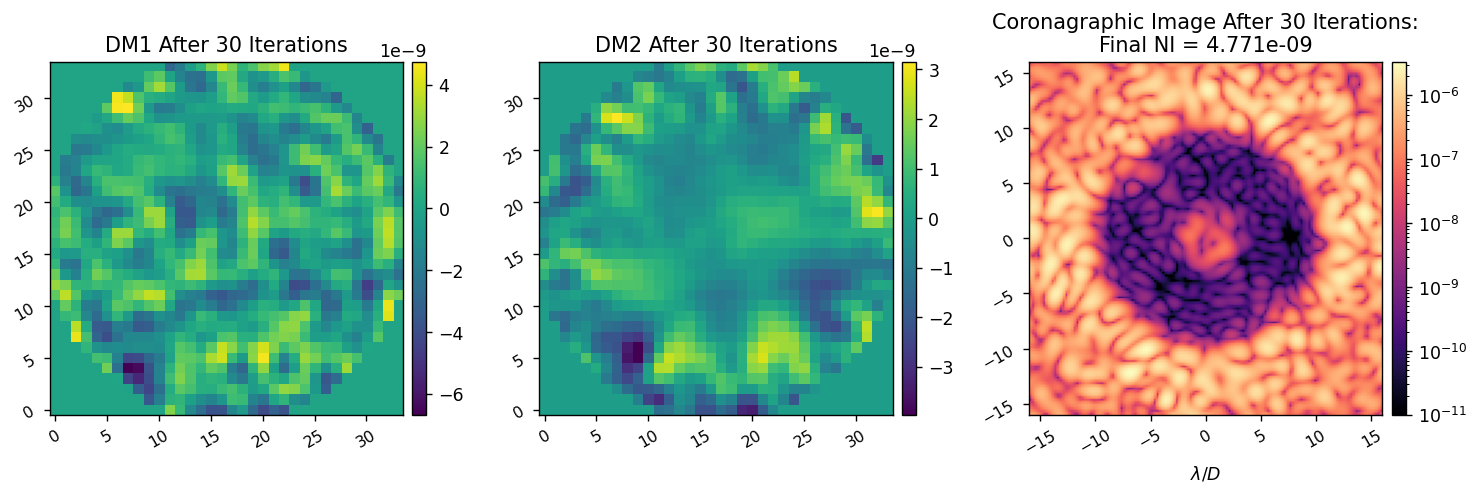

In [51]:
imshow3(amp, opd, ref_im, 
             f'Pupil Amplitude:\nRMS Amplitude Errors = {rms_amp:.4f}', f'Pupil WFE:\nRMS WFE = {1e9*rms_wfe:.3f}nm', 
             f'Initial Coronagraphic Image:\nInitial NI = {mean_ni_0:.3e}',
             npix1=c.npix, npix2=c.npix, 
             lognorm3=True, vmin3=1e-11, xlabel3='$\lambda/D$', pxscl3=c.psf_pixelscale_lamD)
imshow3(dm1_commands[-1], dm2_commands[-1], images[-1],
             'DM1 After 30 Iterations', 'DM2 After 30 Iterations',
             f'Coronagraphic Image After 30 Iterations:\nFinal NI = {mean_ni:.3e}',
             cmap1='viridis', cmap2='viridis',
             pxscl3=c.psf_pixelscale_lamD, xlabel3='$\lambda/D$', lognorm3=True, vmin3=1e-11)

Running iEFC...
	Closed-loop iteration 1 / 10
	Mean NI of this iteration: 3.059e-06


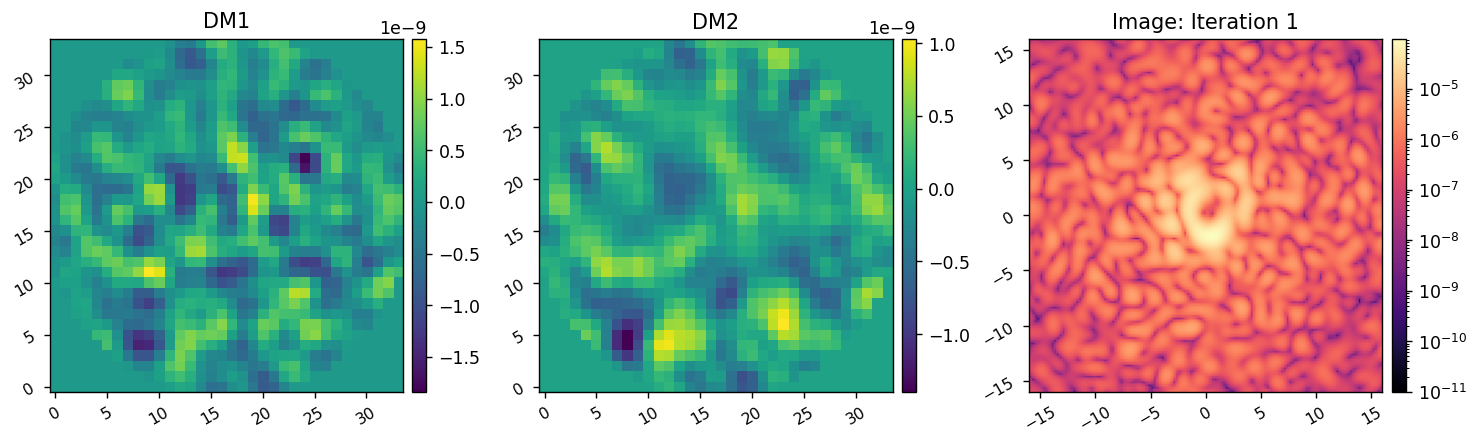

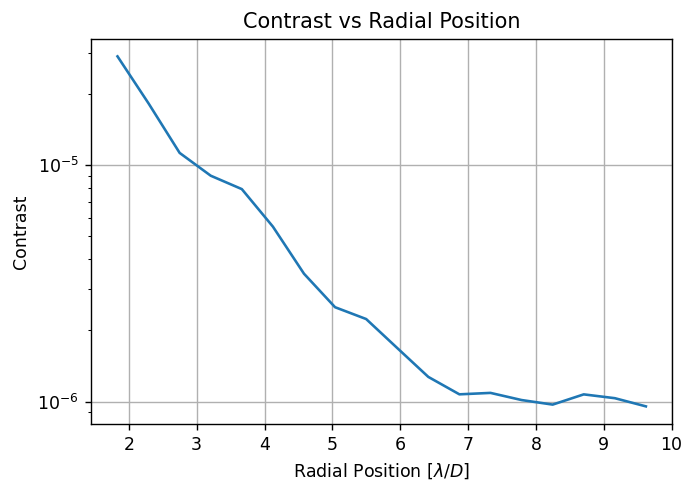

	Closed-loop iteration 2 / 10
	Mean NI of this iteration: 1.460e-06


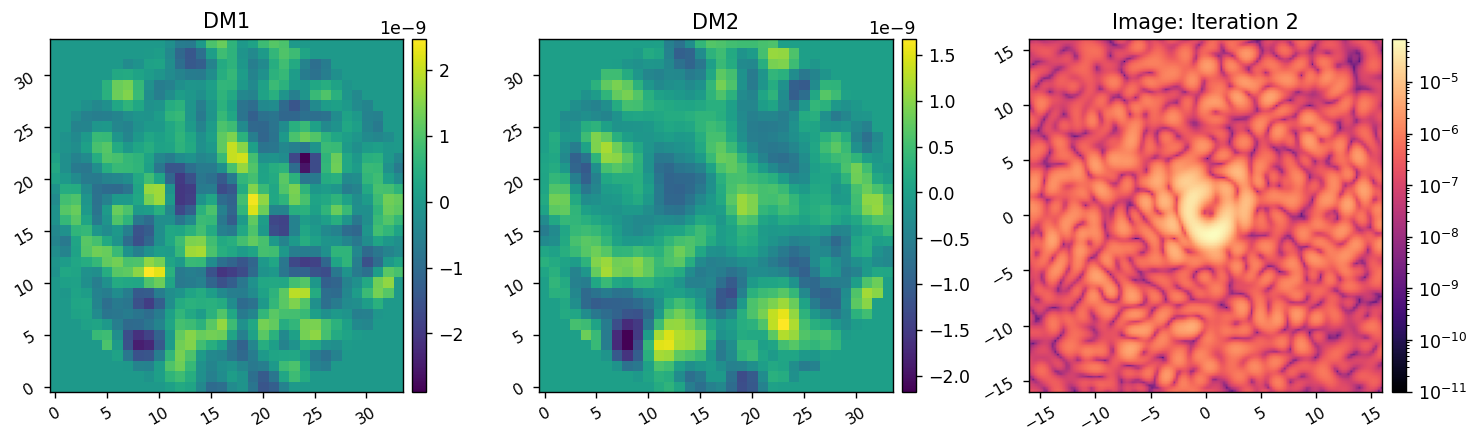

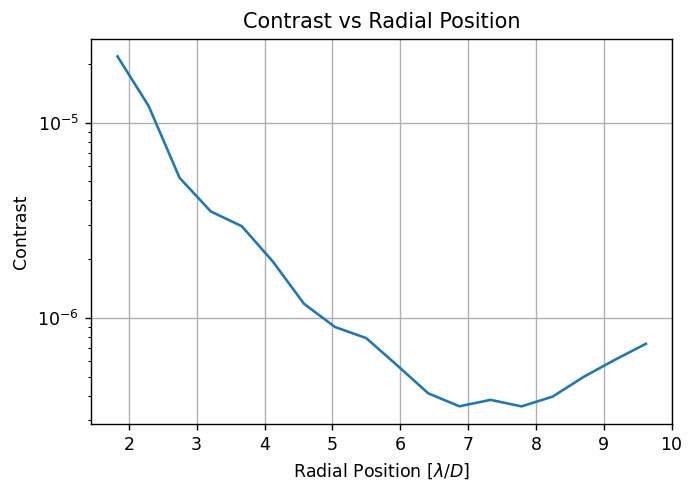

	Closed-loop iteration 3 / 10
	Mean NI of this iteration: 8.710e-07


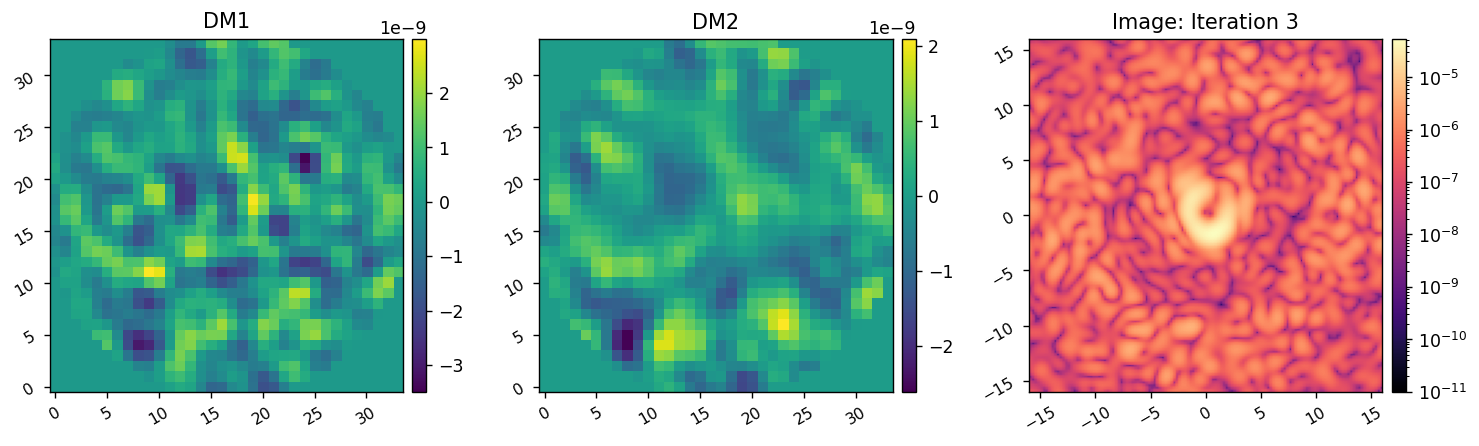

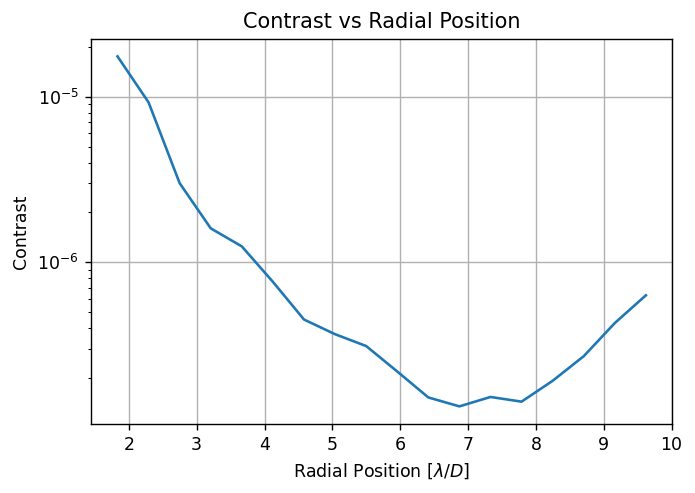

	Closed-loop iteration 4 / 10
	Mean NI of this iteration: 6.232e-07


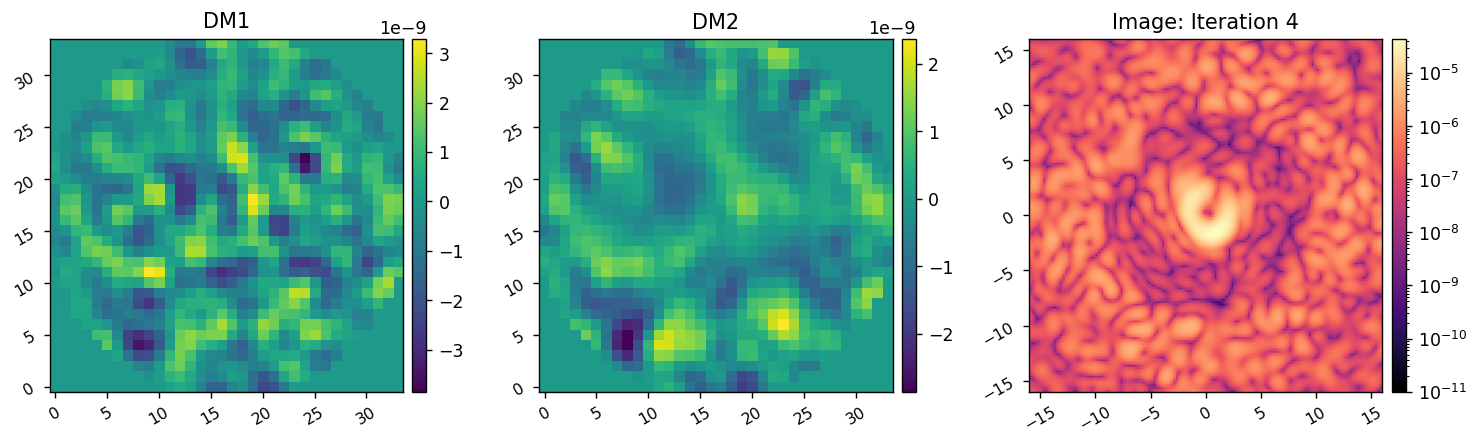

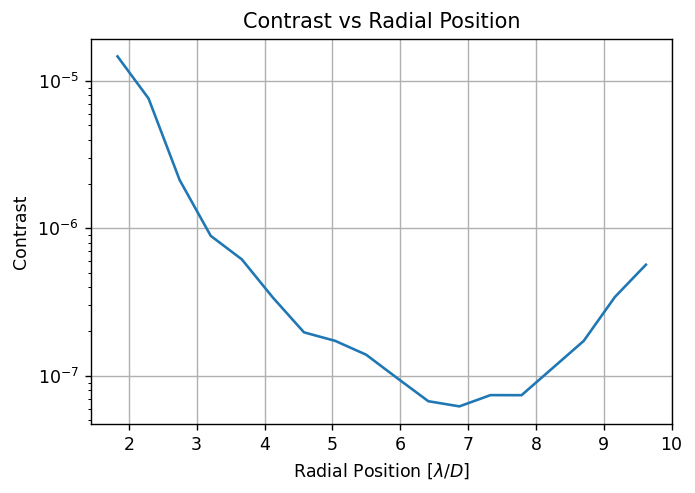

	Closed-loop iteration 5 / 10
	Mean NI of this iteration: 4.991e-07


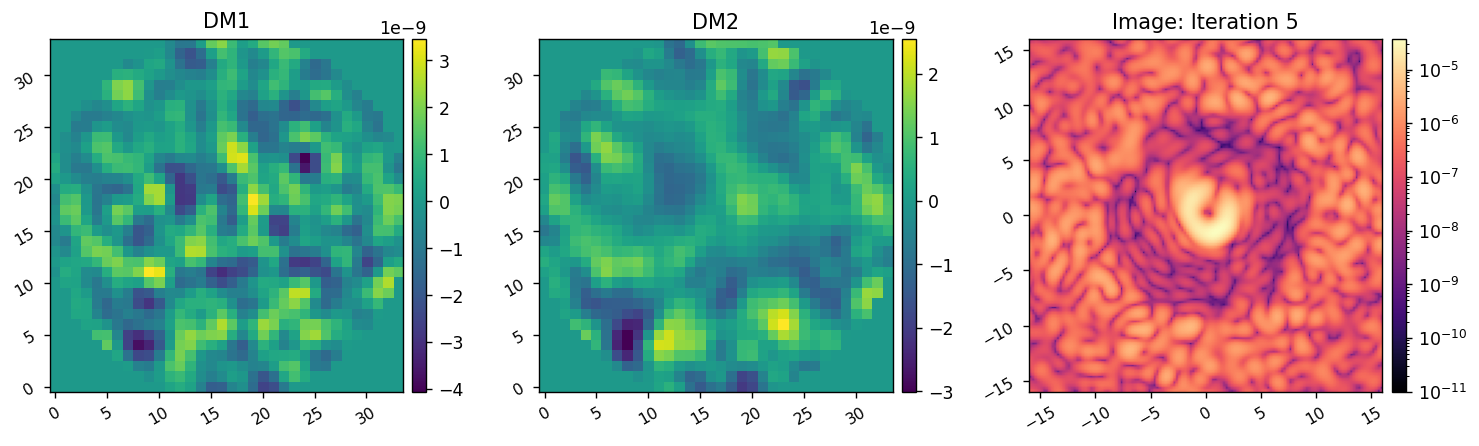

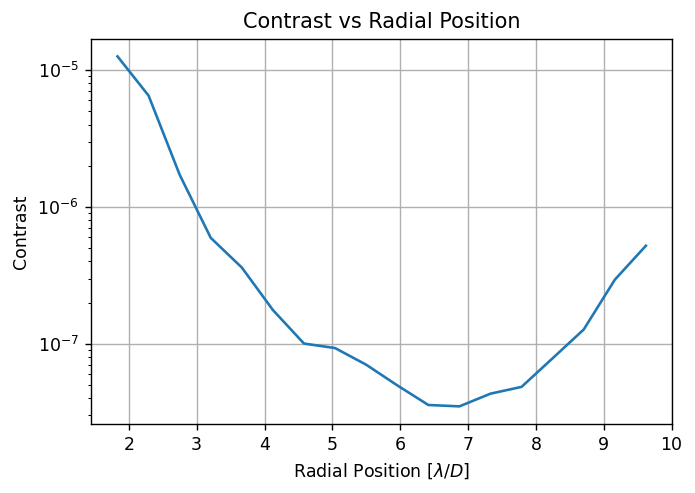

	Closed-loop iteration 6 / 10
	Mean NI of this iteration: 4.242e-07


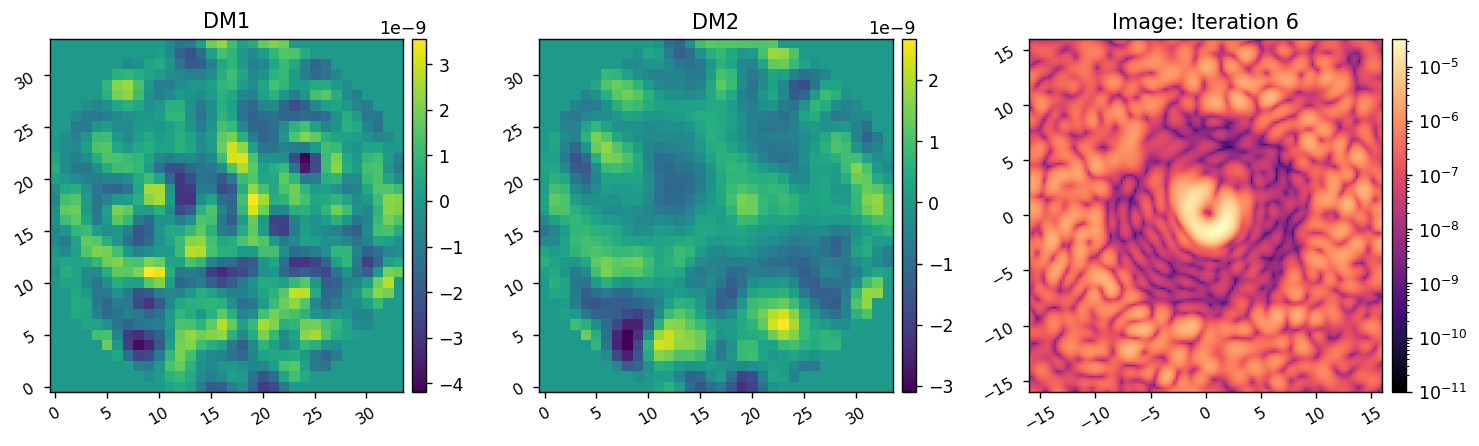

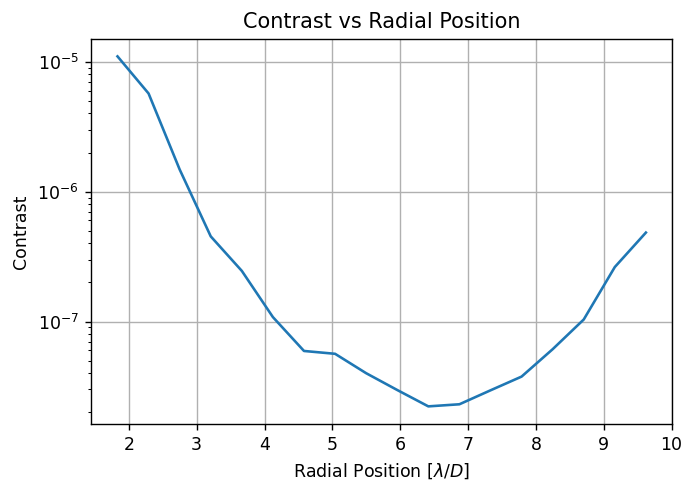

	Closed-loop iteration 7 / 10
	Mean NI of this iteration: 3.717e-07


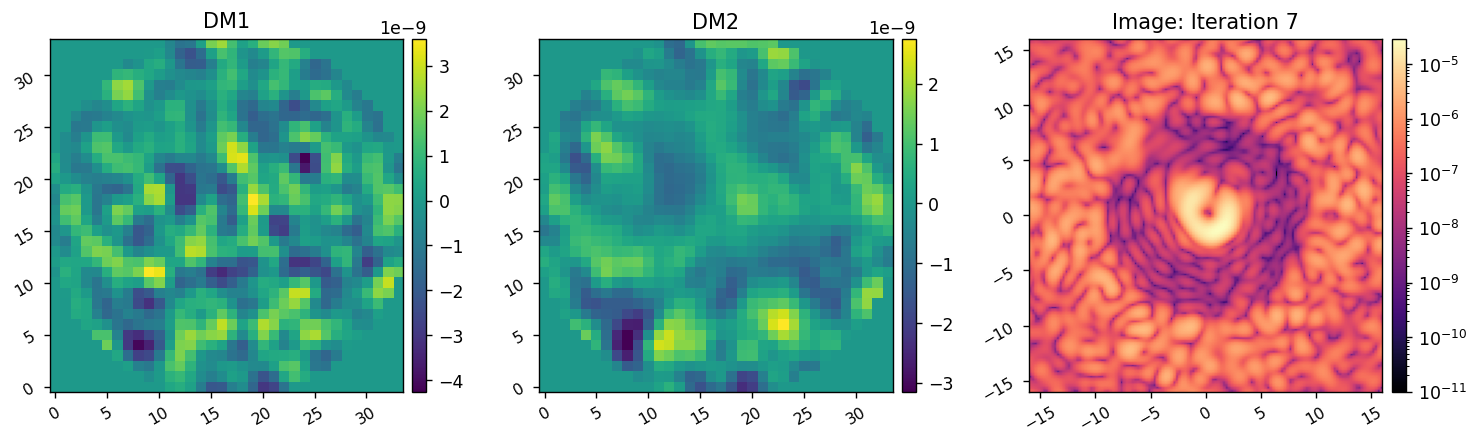

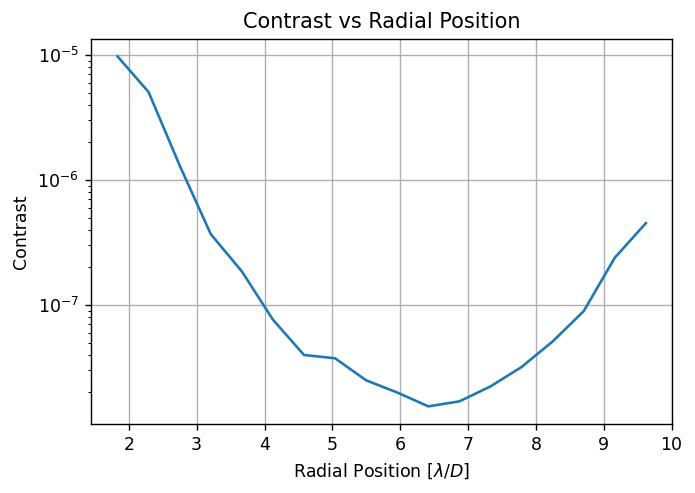

	Closed-loop iteration 8 / 10
	Mean NI of this iteration: 3.308e-07


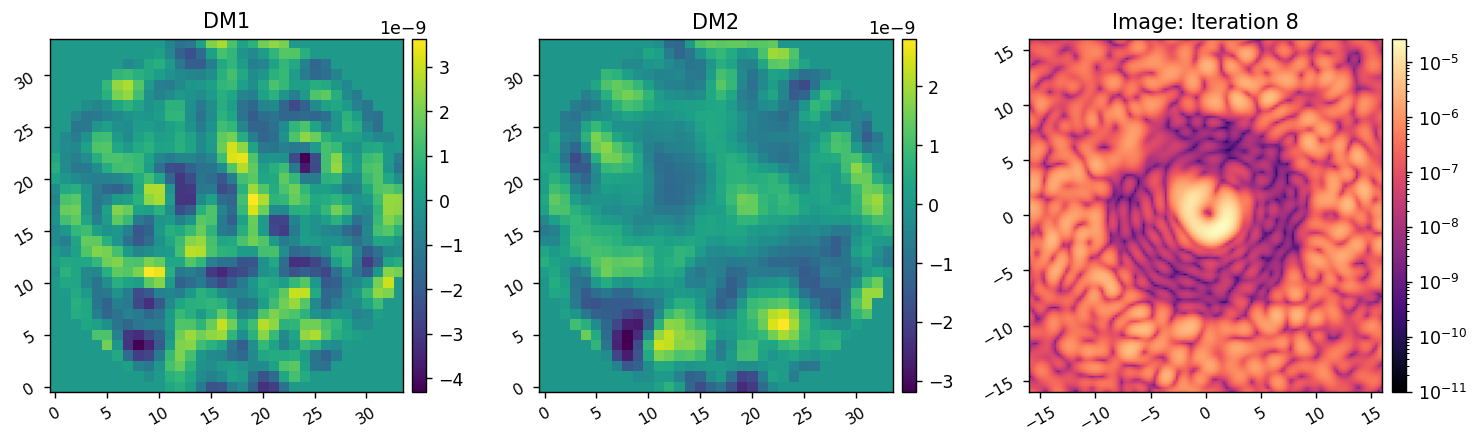

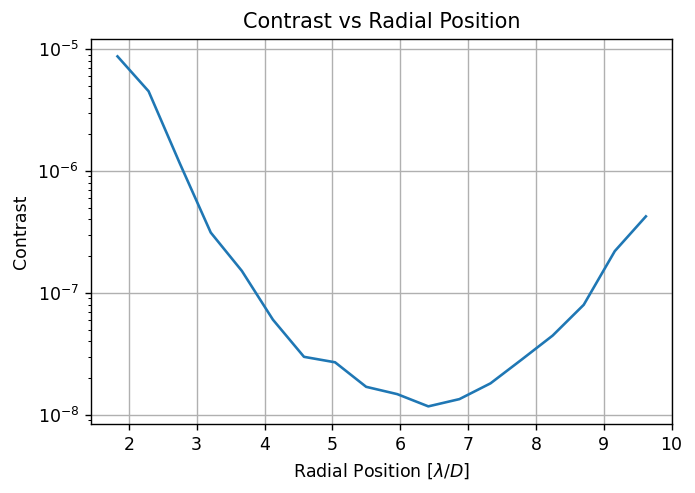

	Closed-loop iteration 9 / 10
	Mean NI of this iteration: 2.972e-07


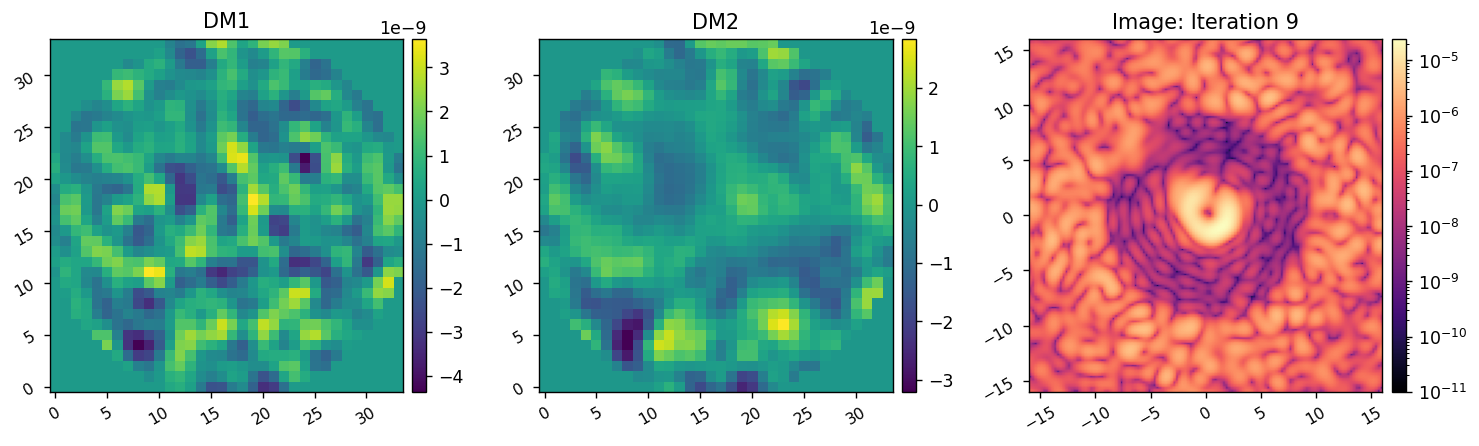

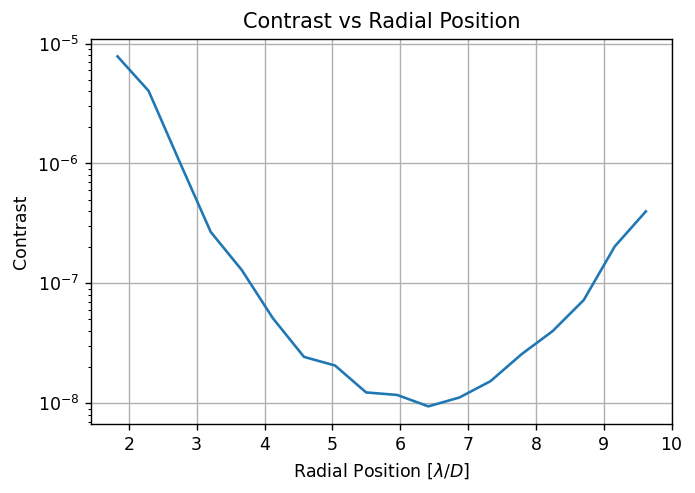

	Closed-loop iteration 10 / 10
	Mean NI of this iteration: 2.688e-07


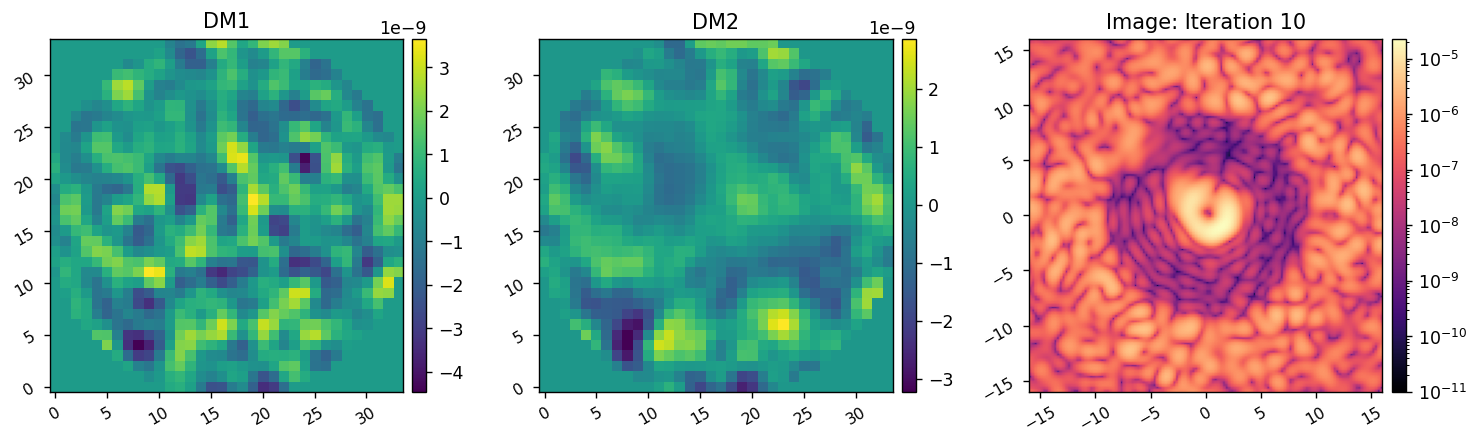

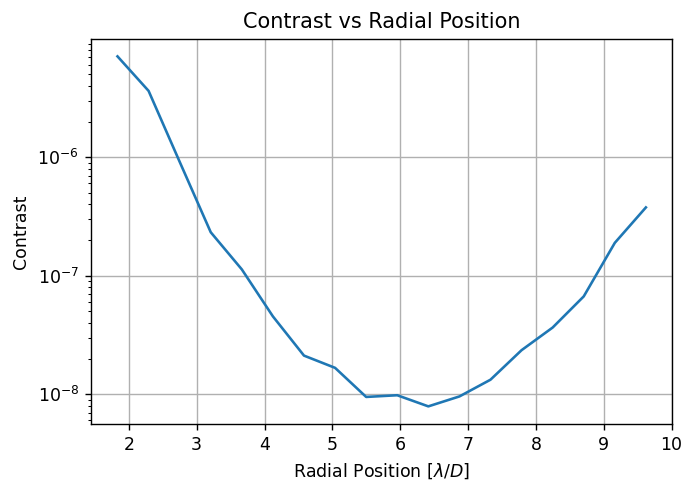

Closed loop completed in 44.606s.


In [38]:
reload(iefc_2dm)
svc.reset_dms()

reg_cond = 1e-1
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_svcs.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(svc, 
                                          control_matrix,
                                          probe_svcs, 
                                          probe_amp, 
                                          utils.ensure_np_array(calib_svcs),
                                          control_mask, 
                                          num_iterations=10, 
                                         starting_iteration=0,
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

Running iEFC...
	Closed-loop iteration 21 / 30
	Mean NI of this iteration: 1.432e-08


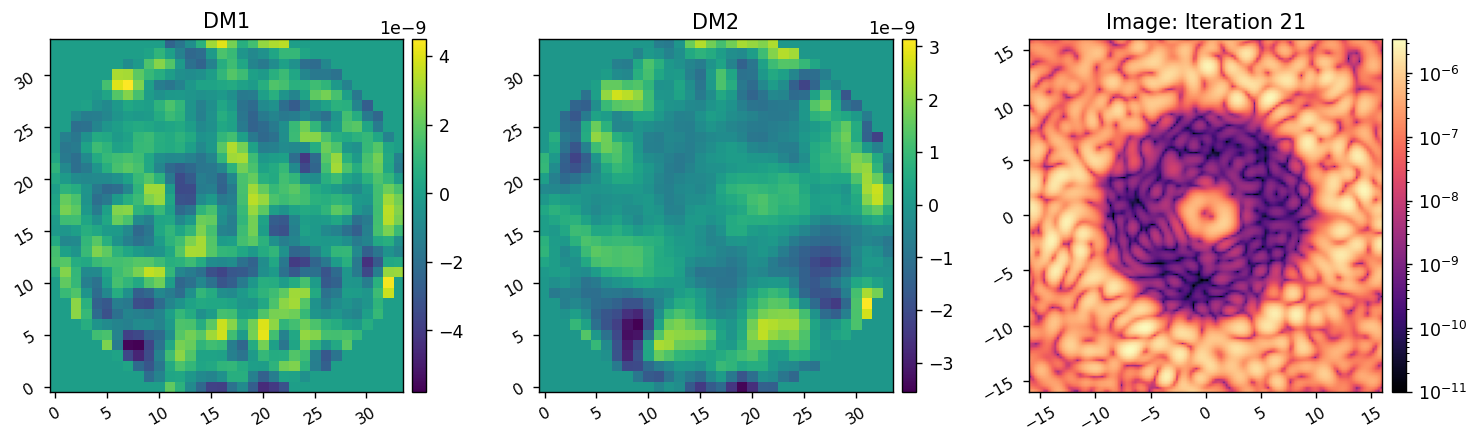

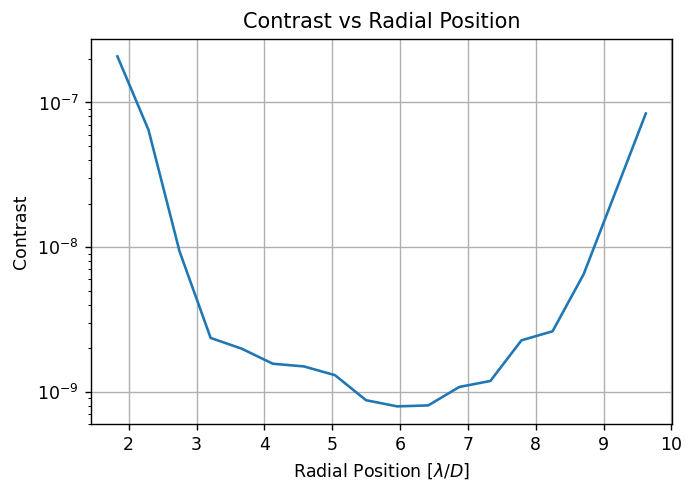

	Closed-loop iteration 22 / 30
	Mean NI of this iteration: 1.058e-08


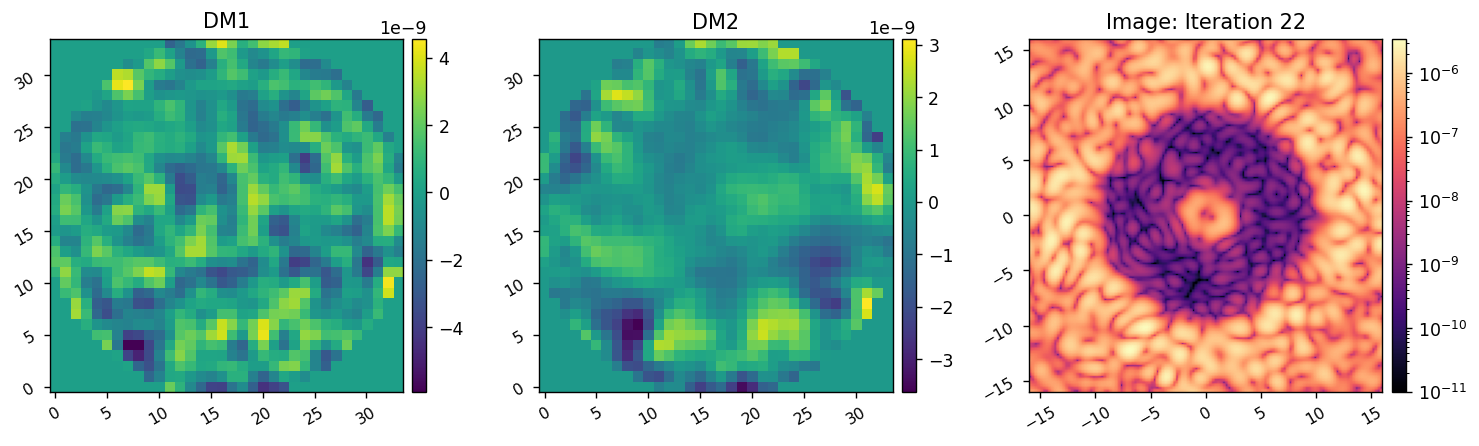

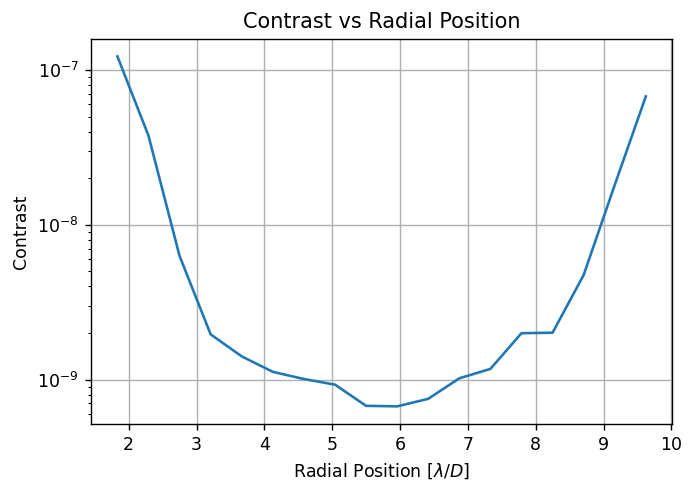

	Closed-loop iteration 23 / 30
	Mean NI of this iteration: 8.506e-09


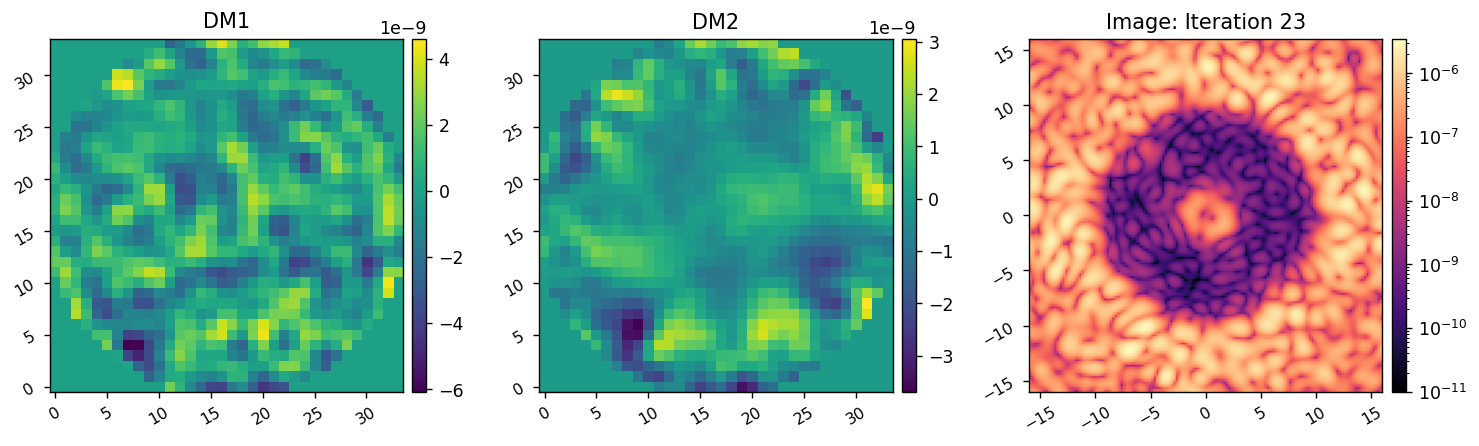

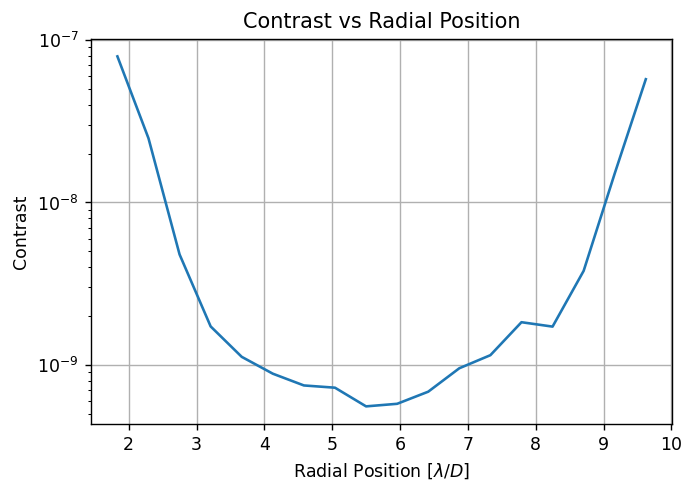

	Closed-loop iteration 24 / 30
	Mean NI of this iteration: 7.262e-09


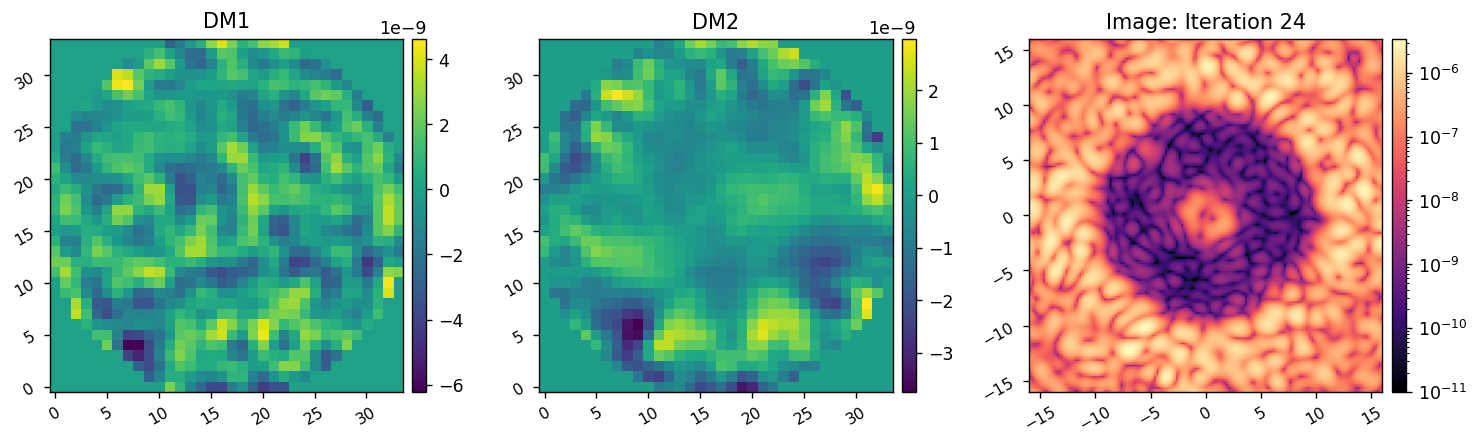

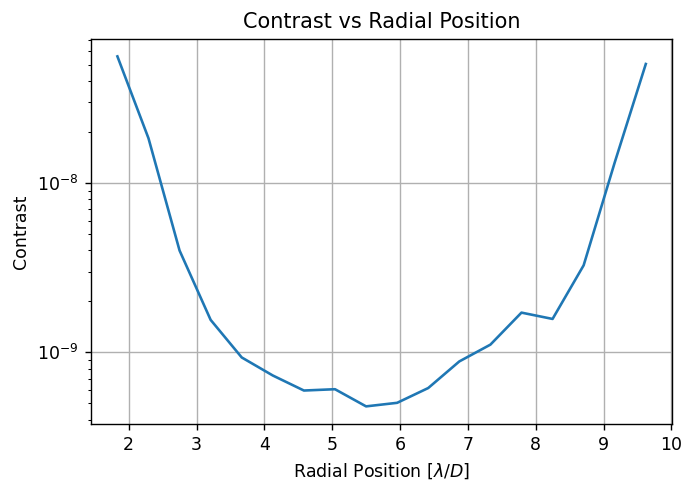

	Closed-loop iteration 25 / 30
	Mean NI of this iteration: 6.462e-09


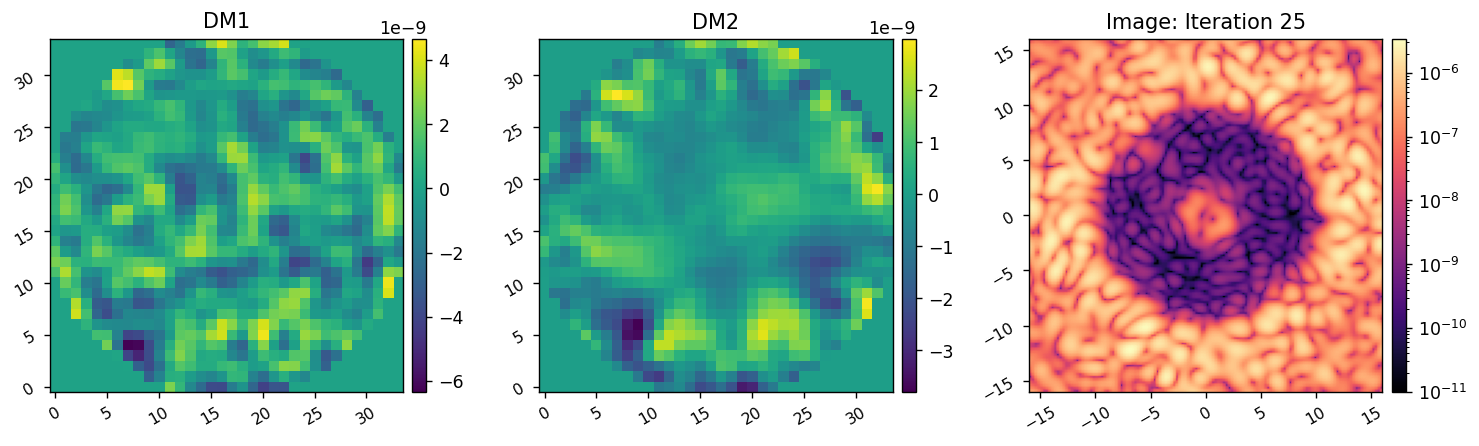

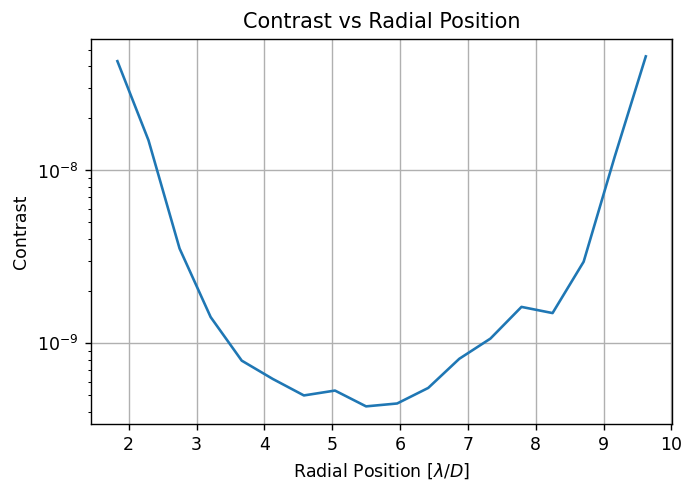

	Closed-loop iteration 26 / 30
	Mean NI of this iteration: 5.913e-09


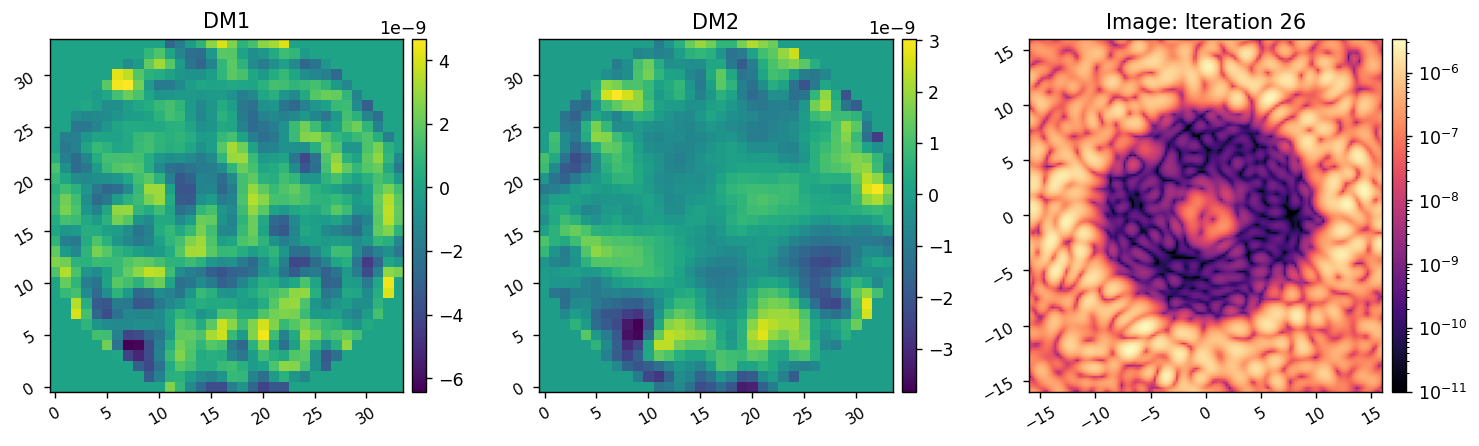

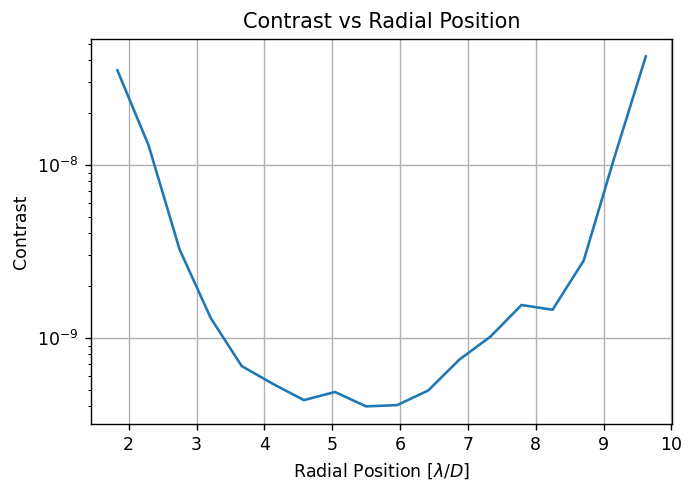

	Closed-loop iteration 27 / 30
	Mean NI of this iteration: 5.514e-09


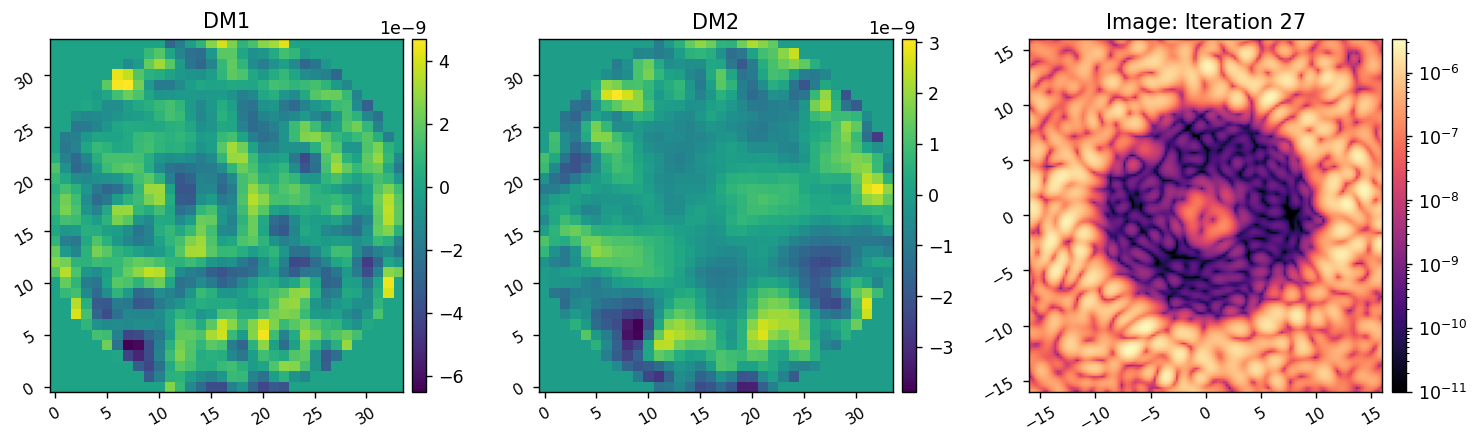

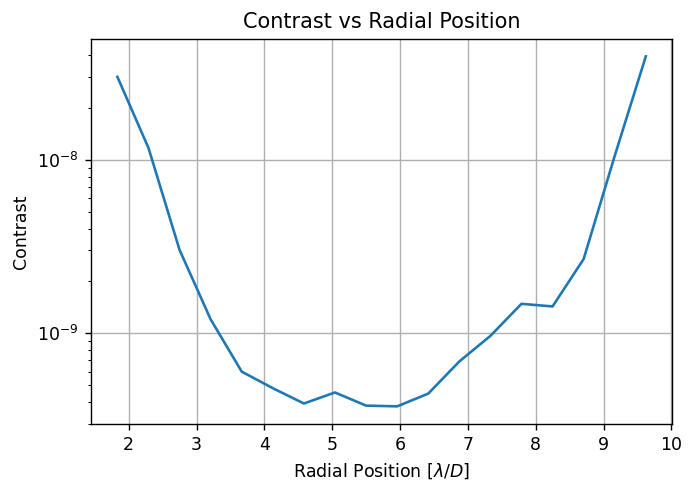

	Closed-loop iteration 28 / 30
	Mean NI of this iteration: 5.210e-09


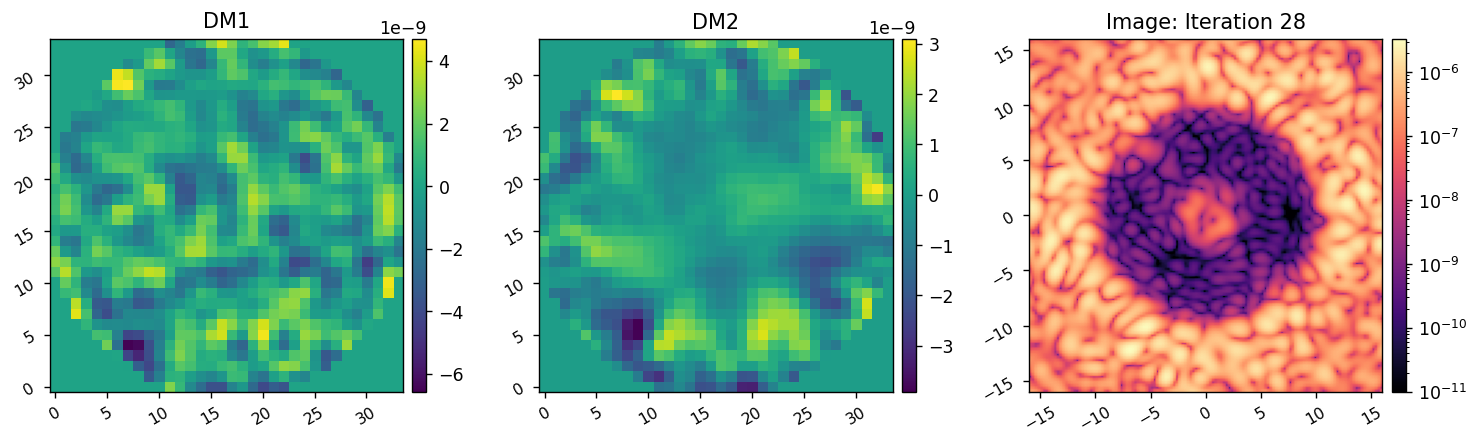

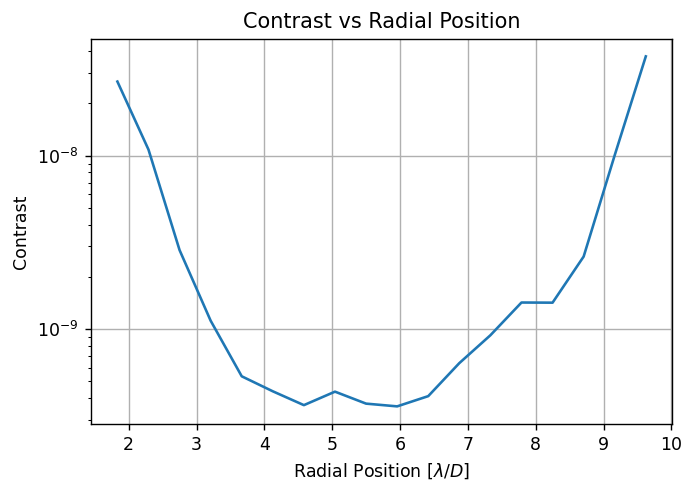

	Closed-loop iteration 29 / 30
	Mean NI of this iteration: 4.969e-09


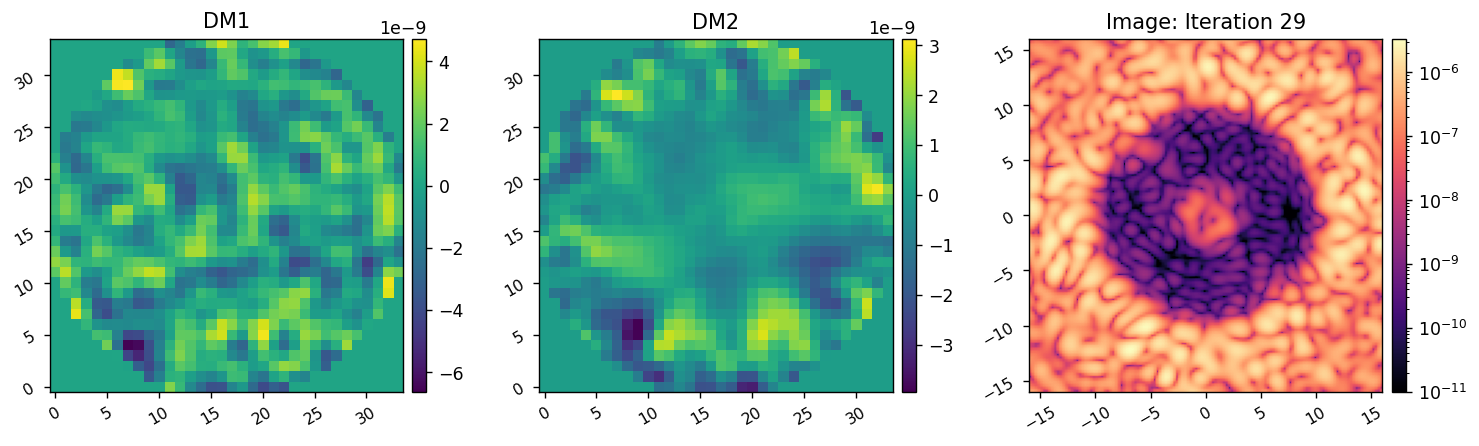

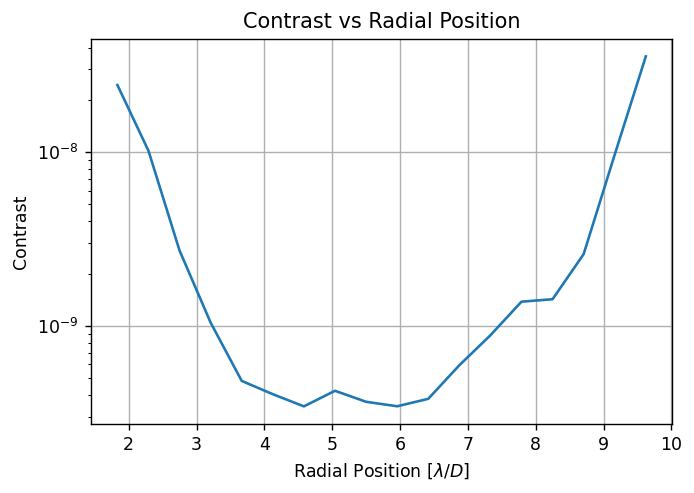

	Closed-loop iteration 30 / 30
	Mean NI of this iteration: 4.771e-09


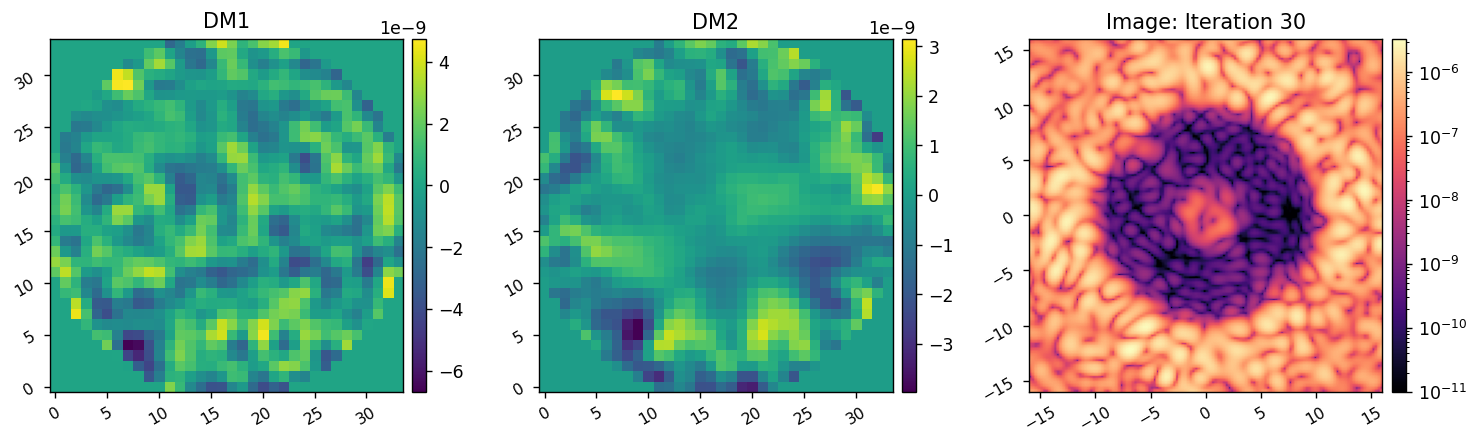

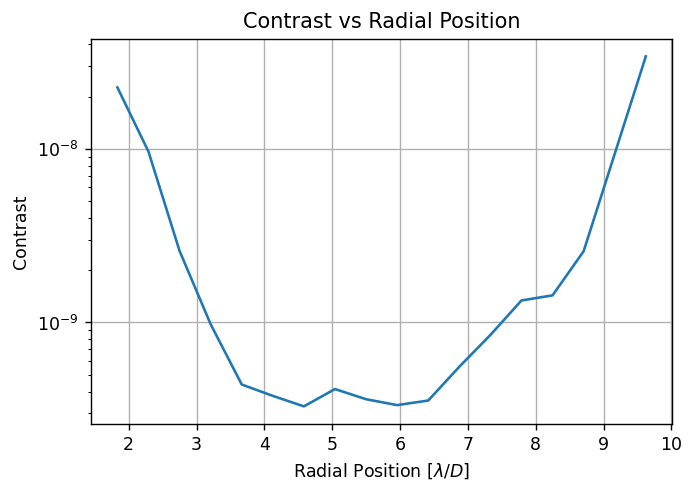

Closed loop completed in 44.921s.


In [40]:
reload(iefc_2dm)
reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_svcs.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(svc, 
                                          control_matrix,
                                          probe_svcs, 
                                          probe_amp, 
                                          utils.ensure_np_array(calib_svcs),
                                          control_mask, 
                                          num_iterations=10, 
                                         starting_iteration=20,
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                         )

In [43]:
mean_ni = np.mean(images[-1][control_mask])

In [49]:
images[-1][control_mask].mean()

1.5793826502317758e-09